In [1]:
import torch
import torch.nn as nn
from copy import deepcopy
from collections import defaultdict, OrderedDict

class XaiHook(nn.Module):
    def __init__(self, module):
        super(XaiHook, self).__init__()
        """
        Hook Handler Module
        
        supported register `module` hooks
        - Activations
        - Linear
        - Convd
        
        like RNN have to use `register_hook` to `torch.nn.Parameter` directly
        
        * Ref: https://pytorch.org/docs/master/nn.html#torch.nn.Module.register_backward_hook
        [Warnings]
        The current implementation will not have the presented behavior 
        for complex Module that perform many operations. In some failure cases, 
        `grad_input` and `grad_output` will only contain the gradients for a subset
        of the inputs and outputs. For such `Module`, you should use 
        `torch.Tensor.register_hook()` directly on a specific input or 
        output to get the required gradients.
        
        """
        self.module = module
    
    def zero_grad(self):
        self.module.zero_grad()

    def register_hook(self, backward=False, hook_fn=None):
        """
        defalut hook_function is save (module, input, output) to (m, i, o)
        if you want to use hook function, change `hook_function` 
        if `hook_function` returns `None` then the original input or output 
        will be flow into next / previous layer, but you can return a modifed
        output/gradient to change the original output/gradient.
        for a Conv2d layer example
        - forward: a `Tensor` type output
        - backward: (gradient_input, weight, bias)
        
        """
        def default_hook_fn(m, i, o):
            """
            forward
             - m: module class
             - i: forward input from previous layer
             - o: forward output to next layer
            backward
             - m: module class
             - i: gradient input to next layer (backward out)
             - o: gradient output from previous layer (backward in)

            args:
             * i, o: tuple type
            """
            self.m = m
            self.i = i
            self.o = o
            
        if hook_fn is None:
            self.hook_fn = default_hook_fn
        else:
            self.hook_fn = hook_fn
        if not backward:
            self.hook = self.module.register_forward_hook(self.hook_fn)
        else:
            self.hook = self.module.register_backward_hook(self.hook_fn)
            
    def close(self):
        self.hook.remove()


class XaiBase(nn.Module):
    def __init__(self):
        super(XaiBase, self).__init__()
        """
        - need to define XaiHook class to use
        - defalut hook_function is save (module, input, output) to (m, i, o)
          if you want to use hook function, change `hook_function` 
        """
        self._reset_maps()
    
    def _reset_maps(self):
        self.maps = OrderedDict()
        
    def _save_maps(self, layer_name, x):
        self.maps[layer_name] = x    
        
    def _register(self, hooks, backward=False, hook_fn=None):
        """
        - need to define XaiHook class to use
        - defalut hook_function is save (module, input, output) to (m, i, o)
          if you want to use hook function, change `hook_function` 
        """
        if not isinstance(hooks, list):
            hooks = [hooks]
        for hook in hooks:
            hook.register_hook(backward=backward, hook_fn=hook_fn)
    
    def _register_forward(self, hooks, hook_fn=None):
        self._register(hooks, backward=False, hook_fn=hook_fn)
        
    def _register_backward(self, hooks, hook_fn=None):
        self._register(hooks, backward=True, hook_fn=hook_fn)
    
    def _reset_hooks(self, hooks):
        if not isinstance(hooks, list):
            hooks = [hooks]
        for hook in hooks:
            hook.close()

    def _return_indices(self, layers, on=True):
        """
        support for cnn layer which have `nn.MaxPool2d`,
        you can turn on/off pooling indices.
        please define a forward function to use it in your model
        '''
        # in your model
        def forward_switch(self, x):
            switches = OrderedDict()
            self.return_indices(on=True)
            for idx, layer in enumerate(self.convs):
                if isinstance(layer, nn.MaxPool2d):
                    x, indices = layer(x)
                    switches[idx] = indices
                else:
                    x = layer(x)
            self.return_indices(on=False)
            return x, switches
        '''
        """
        if on:
            for layer in layers:
                if isinstance(layer, nn.MaxPool2d):
                    layer.return_indices = True
        else:
            for layer in layers:
                if isinstance(layer, nn.MaxPool2d):
                    layer.return_indices = False  
                    
                    
class XaiModel(XaiBase):
    def __init__(self, model):
        super(XaiModel, self).__init__()
        self.model = deepcopy(model)
        self.model.cpu()
        self.model.eval()
        
    def _one_hot(self, targets, module_name):
        """
        one hot vectorize the target tensor for classification purpose.
        the `module` with respect to `module_name` must have `out_features` attribution.
        args:
        - targets: torch.LongTensor, target classes that have size of mini-batch
        - module_name: str, feature name for Fully-Connected Network or any Task-specific Network
        return:
        - one hot vector of targets
        """
        assert isinstance(targets, torch.LongTensor), "`targets` must be `torch.LongTensor` type"
        assert isinstance(module_name, str), "`module_name` must be `str` type"
        modules = self.model._modules[module_name]
        if isinstance(modules, nn.Sequential):
            last_layer = modules[-1]
        else:
            last_layer = modules
        try:
            last_layer.out_features 
        except AttributeError as e:
            is_linear = isinstance(last_layer, nn.Linear)
            print(f"last layer of module `{module_name}` doesn't have `out_features` attribute")
            print()
            if not is_linear:
                print(f"type of the last layer is `{type(last_layer)}`")
                print("the last layer is not `torch.nn.linear.Linear` class")
                print("create `.out_featrues` attribution in the custom module")
                
        target_size = last_layer.out_features
        B = targets.size(0)
        one_hot = torch.zeros((B, target_size))
        one_hot.scatter_(1, targets.unsqueeze(1), 1.0)
        return one_hot.to(targets.device)
    
    def _find_target_layer_idx(self, module_name, layer_names):
        assert isinstance(layer_names, list) or isinstance(layer_names, tuple), "use list for `layer_names`"
        layer_names = [l.lower() for l in layer_names]
        idxes = defaultdict(list)
        modules = self.model._modules[module_name]
        assert isinstance(modules, nn.Sequential), "use this function for `nn.Sequential` type modules"
        for idx, layer in modules.named_children():
            l_name = type(layer).__name__.lower()
            if l_name in layer_names:
                idxes[l_name].append(int(idx))

        return idxes

In [2]:
class ChannelAttention(nn.Module):
    """Channel Attention Module"""
    def __init__(self, C, ratio):
        """
        Method in [arXiv:1807.06521]
        args:
         - C: channel of input features
         - H: height of input features
         - W: width of input features
         - hid_size: hidden size of shallow network
         - ratio: reduction ratio
        """
        super(ChannelAttention, self).__init__()
        assert isinstance(2*C // ratio, int), "`2*C // ratio` must be int "
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.shallow_net = nn.Sequential(
            nn.Linear(2*C, 2*C // ratio),
            nn.ReLU(),
            nn.Linear(2*C // ratio, 2*C),
        )
    
    def forward(self, x):
        # (B, C, H, W) > (B, 2*C, 1, 1)
        x = torch.cat([self.maxpool(x), self.avgpool(x)], dim=1)
        # (B, 2*C) > (B, 2*C//2) > (B, 2*C)
        x = self.shallow_net(x.squeeze(-1).squeeze(-1))
        # (B, C), (B, C)
        x_max, x_avg = torch.chunk(x, 2, dim=1)
        # not using softmax in paper: something like gate function
        x = torch.sigmoid(x_max + x_avg)
        return x.unsqueeze(-1).unsqueeze(-1)

In [3]:
class SpatialAttention(nn.Module):
    """Spatial Attention Module"""
    def __init__(self, H, W, K_H=7, K_W=7, S_H=1, S_W=1):
        """
        Method in [arXiv:1807.06521]
        args:
         - H: height of input features
         - W: width of input features
         - K_H: height of kernel size
         - K_W: width of kernel size
         - S_H: stride height of conv layer
         - S_W: stride width of conv layer
        """
        super(SpatialAttention, self).__init__()
        P_H = self.cal_padding_size(H, K_H, S_H)
        P_W = self.cal_padding_size(W, K_W, S_W)
        kernel_size = (K_H, K_W)
        stride = (S_H, S_W)
        padding = (P_H, P_W)
        # same padding conv layer
        self.conv_layer = nn.Conv2d(2, 1, kernel_size, stride, padding)
    
    def cal_padding_size(self, x, K, S):
        return int((S * (x-1) + K - x) / 2)
    
    def forward(self, x):
        # (B, C, H, W) > (B, 1, H, W)
        x_max, _ = torch.max(x, dim=1, keepdim=True)
        x_avg = torch.mean(x, dim=1, keepdim=True)
        # (B, 2, H, W)
        x = torch.cat([x_max, x_avg], dim=1)
        # (B, 2, H, W) > (B, 1, H, W)
        x = self.conv_layer(x)
        # return gated features
        return torch.sigmoid(x)

In [4]:
class CBAM(nn.Module):
    """Convolution Block Attention Module"""
    def __init__(self, C, H, W, ratio, K_H=7, K_W=7, S_H=1, S_W=1):
        """
        Method in [arXiv:1807.06521]
        args:
         - C: channel of input features
         - H: height of input features
         - W: width of input features
         - ratio: reduction ratio
         - K_H: height of kernel size
         - K_W: width of kernel size
         - S_H: stride height of conv layer
         - S_W: stride width of conv layer
         
        return:
         - attentioned features, size = (B, C, H, W)
        """
        super(CBAM, self).__init__()
        self.channel_attn = ChannelAttention(C, ratio)
        self.spatial_attn = SpatialAttention(H, W, K_H, K_W, S_H, S_W)
        
    def forward(self, x, return_attn=False):
        """
        return: attentioned features, size = (B, C, H, W)
        """
        out = x
        c_attn = self.channel_attn(out)
        out = c_attn * out
        s_attn = self.spatial_attn(out)
        out = s_attn * out
        if return_attn:
            return out, (c_attn, s_attn)
        return out

In [5]:
import torch
import torch.nn as nn
from collections import OrderedDict

class CnnWithCBAM(XaiBase):
    def __init__(self):
        super(CnnWithCBAM, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (B, 1, 28, 28) > (B, 32, 24, 24)
            CBAM(32, 24, 24, 16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 24, 24) > (B, 32, 12, 12)
            nn.Conv2d(32, 64, 3),  # (B, 32, 12, 12) > (B, 64, 10, 10)
            CBAM(64, 10, 10, 16),
            nn.ReLU(), 
            nn.MaxPool2d(2),  # (B, 64, 10, 10) > (B, 64, 5, 5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):        
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def forward_map(self, x):
        self._reset_maps()
        for i, layer in enumerate(self.convs):
            layer_name = type(layer).__name__.lower()
            if layer_name == "cbam":
                x, attns = layer(x, return_attn=True)
                self._save_maps(f"{i}"+layer_name, attns)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
class Cnn(XaiBase):
    def __init__(self):
        super(Cnn, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 5),  # (B, 1, 28, 28) > (B, 32, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 24, 24) > (B, 32, 12, 12)
            nn.Conv2d(32, 64, 3),  # (B, 32, 12, 12) > (B, 64, 10, 10)
            nn.ReLU(), 
            nn.MaxPool2d(2),  # (B, 64, 10, 10) > (B, 64, 5, 5)
            nn.Conv2d(64, 128, 2),  # (B, 128, 5, 5) > (B, 128, 4, 4)
            nn.ReLU(), 
            nn.MaxPool2d(2),  # (B, 128, 4, 4) > (B, 128, 2, 2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*2*2, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):        
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def forward_map(self, x):
        self._reset_maps()
        for i, layer in enumerate(self.convs):
            layer_name = type(layer).__name__.lower()
            if layer_name == "relu":
                x, attns = layer(x, return_attn=True)
                self._save_maps(f"{i}"+layer_name, attns)
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
model = Cnn()

In [81]:
model = CnnWithCBAM()

---

In [9]:
import torch.nn.functional as F

class GradCAM(XaiModel):
    """GradCAM"""
    def __init__(self, model, norm_mode=1):
        """
        norm mode
        - 1 ( 0, 1) min-max normalization
        - 2 (-1, 1) min-max normalization
        - 3 mean-std normalization
        """
        super(GradCAM, self).__init__(model)
        self.norm_mode = norm_mode
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        relu_idxes = self._find_target_layer_idx(module_name="convs", layer_names=["relu"])
        self.last_relu_idx = relu_idxes["relu"][-1]
        # get Rectified Conv Features Maps
        self.f_hook = XaiHook(self.model.convs[self.last_relu_idx])
        self.b_hook = XaiHook(self.model.convs[self.last_relu_idx])
        self.register_hooks()
    
    def register_hooks(self):
        self._register_forward(self.f_hook, hook_fn=None)
        self._register_backward(self.b_hook, hook_fn=None)
    
    def reset_hooks(self):
        self.f_hook.close()
        self.b_hook.close()
    
    def cal_gradcam(self):
        # (B, C, H, W) > (B, C, 1, 1)
        alpha = self.global_avgpool(self.b_hook.i[0])
        # sum( (B, C, 1, 1) * (B, C, H, W) , dim=1) > (B, 1, H, W)
        gradcam = torch.relu((alpha * self.f_hook.o).sum(1, keepdim=True))
        return gradcam
        
    def post_processing(self, gradcam, H, W):
        """
        interpolate(up sample) & normalize
        https://pytorch.org/docs/stable/nn.functional.html#interpolate
        """
        gradcam = F.interpolate(gradcam, size=(H, W), mode="bilinear", align_corners=False)
        gradcam = self.normalization(gradcam)
        return gradcam
    
    def normalization(self, tensor):
        B, C, H, W = tensor.size()
        tensor = tensor.view(B, -1)
        t_min = tensor.min(dim=1, keepdim=True)[0]
        t_max = tensor.max(dim=1, keepdim=True)[0]
        t_mean = tensor.mean(dim=1, keepdim=True)
        t_std = tensor.std(dim=1, keepdim=True)
        if self.norm_mode == 1:
            tensor -= t_min
            tensor /= (t_max - t_min + 1e-10)
        elif self.norm_mode == 2:
            tensor -= t_min
            tensor *= 2
            tensor /= (t_max - t_min + 1e-10)
        elif self.norm_mode == 3:
            tensor -= t_mean
            tensor /= t_std
        return tensor.view(B, C, H, W)
        
    def get_attribution(self, x, targets):
        *_, H, W = x.size()
        self.model.zero_grad()
        
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        
        gradcam = self.cal_gradcam()
        gradcam = self.post_processing(gradcam, H, W)
        
        return gradcam.detach()

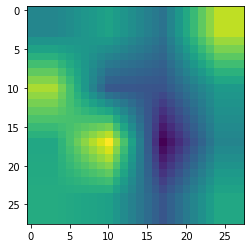

In [16]:
import matplotlib.pyplot as plt

gradcam_model = GradCAM(model)
x = torch.randn(1, 1, 28, 28)
targets = torch.LongTensor([2])
gradcam = gradcam_model.get_attribution(x, targets)
plt.imshow(gradcam.squeeze())
plt.show()

In [17]:
class GuidedBackprop(XaiModel):
    """GuidedBackprop"""
    def __init__(self, model):
        super(GuidedBackprop, self).__init__(model)
        self.register_guided_hooks(self.model.convs)
    
    def reset_f_outputs(self):
        self.f_outputs = []
    
    def register_guided_hooks(self, layers):
        self.relu_f_hooks = []
        self.relu_b_hooks = []
        self.reset_f_outputs()
        for layer in layers:
            layer_name = type(layer).__name__
            if layer_name.lower() == "relu":
                f_hook = XaiHook(layer)
                b_hook = XaiHook(layer)
                self.relu_f_hooks.append(f_hook)
                self.relu_b_hooks.append(b_hook)
                
        def guided_forward(m, i, o):
            self.f_outputs.append(o.data)  
            
        def guided_backward(m, i, o):
            deconv_grad = o[0].clamp(min=0)  # o: backward input
            forward_output = self.f_outputs.pop(-1)
            forward_mask = forward_output.ne(0.0).type_as(forward_output)
            grad_in = deconv_grad * forward_mask
            return (grad_in, )
        
        # register forward hooks
        self._register_forward(self.relu_f_hooks, hook_fn=guided_forward)
        self._register_backward(self.relu_b_hooks, hook_fn=guided_backward)
        
    def get_attribution(self, x, targets):
        x.requires_grad_(True)
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(False)
        return x_grad

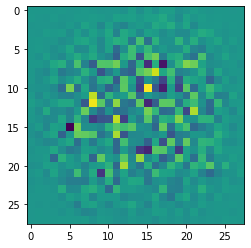

In [18]:
guided_model = GuidedBackprop(model)
grad = guided_model.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

In [19]:
class VanillaGrad(XaiModel):
    """VanillaGrad"""
    def __init__(self, model):
        super(VanillaGrad, self).__init__(model)
        
    def get_attribution(self, x, target):
        """vanilla gradient"""
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(requires_grad=False)
        return x_grad

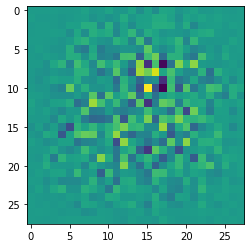

In [20]:
vanillagrad = VanillaGrad(model)
grad = vanillagrad.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

In [21]:
class GradInput(XaiModel):
    """GradInput"""
    def __init__(self, model):
        super(GradInput, self).__init__(model)
        
    def get_attribution(self, x, target):
        """vanilla gradient*input"""
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.model(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(requires_grad=False)
        
        return x_grad * x.data

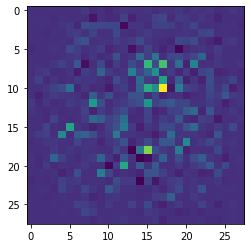

In [22]:
gradinput = GradInput(model)
grad = gradinput.get_attribution(x, targets)
plt.imshow(grad.squeeze())
plt.show()

In [23]:
class DeconvNet(XaiModel):
    """DeconvNet"""
    def __init__(self, model, module_name="convs"):
        super(DeconvNet, self).__init__(model)
        layer_names = ["conv2d", "maxpool2d"]
        self.module_name = module_name
        self.deconvs_indices = self.find_idxes(module_name, layer_names)
        self.layers = self.make_layers(module_name)
        self.init_weights(module_name, layer_name="conv2d")
        
    def find_idxes(self, module_name, layer_names):
        """
        args:
        - module_name
        - layer_names: 
        
        return:
        get `deconvs_indices` for the `module_name`, 
        - key: decovnet layer name 
        - values: indices dict match to {convnet:decovnet}
        """
        convs_indices = self._find_target_layer_idx(module_name, layer_names)
        last_layer_num = len(self.model._modules[module_name]) - 1
        deconvs_indices = defaultdict(dict)
        
        for l_name in layer_names:
            idxes = (last_layer_num - torch.LongTensor(convs_indices[l_name])).tolist()
            deconvs_indices[l_name] = dict(zip(convs_indices[l_name], idxes))
            if l_name == "conv2d":
                deconvs_indices[l_name+"-bias"] = dict(zip(
                    convs_indices[l_name], idxes[1:]+[None]))
            
        return deconvs_indices
    
    def make_layers(self, module_name):
        """
        maxunpool > relu > conv 
        """
        layers = []
        modules = self.model._modules[module_name]
        for layer in modules:
            if isinstance(layer, nn.Conv2d):
                temp_layer = nn.ConvTranspose2d(layer.out_channels,
                                                layer.in_channels,
                                                layer.kernel_size, 
                                                layer.stride, 
                                                layer.padding,
                                                layer.output_padding,
                                                layer.groups, 
                                                False,  # bias
                                                layer.dilation,
                                                layer.padding_mode)
                layers.append(temp_layer)
            elif isinstance(layer, nn.MaxPool2d):
                temp_layer = nn.MaxUnpool2d(layer.kernel_size,
                                            layer.stride,
                                            layer.padding)
                layers.append(temp_layer)
            else:
                layers.append(layer)
        return nn.Sequential(*reversed(layers))
    
    def init_weights(self, module_name, layer_name):
        convs = self.model._modules[module_name]
        conv_indices = self.deconvs_indices[layer_name]
        conv_bias_indices = self.deconvs_indices[layer_name+"-bias"]
        for i, layer in enumerate(convs):
            if type(layer).__name__.lower() == layer_name:
                # ex: 3 conv layers (conv, relu, maxpool)
                # 'conv2d': {0: 8, 3: 5, 6: 2}
                # 'conv2d-bias': {0: 5, 3: 2, 6: None}
                
                deconv_idx = conv_indices.get(i)
                weight = convs[i].weight.data
                self.layers[deconv_idx].weight.data = weight
                
                deconv_bias_idx = conv_bias_indices.get(i)
                if deconv_bias_idx is not None:
                    bias = convs[i].bias
                    self.layers[deconv_bias_idx].bias = bias
                
                            
    def get_attribution(self, x, targets):
        unpool_locations = self.deconvs_indices["maxpool2d"]
        unpool_locations = {v: k for k, v in unpool_locations.items()}
        convs = self.model._modules[self.module_name]

        switches = OrderedDict()
        self._reset_maps()
        self._return_indices(convs, on=True)
        for i, layer in enumerate(convs):
            if isinstance(layer, nn.MaxPool2d):
                x, switch = layer(x)
                switches[i] = switch
            else:
                x = layer(x)
                
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.MaxUnpool2d):
                j = unpool_locations[i]
                x = layer(x, switches[j])
            elif isinstance(layer, nn.ConvTranspose2d):
                x = layer(x)
                layer_name = type(layer).__name__.lower() + f"-{i}"
                self._save_maps(layer_name, x.data)
            else:
                x = layer(x)
        self._return_indices(convs, on=False)
        x_ret = x.clone().detach().data
        return x_ret

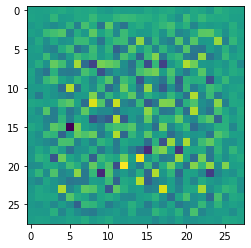

In [24]:
deconvnet = DeconvNet(model)
deconv = deconvnet.get_attribution(x, targets)
plt.imshow(deconv.squeeze())
plt.show()

In [25]:
class relLinear(XaiHook):
    """relLinear"""
    def __init__(self, module, use_rho=False):
        """
        forward
        > input: (B, in_f)
        > output: (B, out_f)
        backward
        > lrp propagation with respect to previous input
        """
        super(relLinear, self).__init__(module)
        self.out_features = self.module.out_features
        self.use_rho = use_rho
        self.register_hook(backward=False, hook_fn=self.f_hook)
        self.register_hook(backward=True, hook_fn=self.b_hook)
        
    def __call__(self, x):
        return self.module(x)
    
    def f_hook(self, m, i, o):
        """
        forward hook
        i: (input,)
        o: output
        
        save forward input and output data
        """
        self.input = i[0].clone().data
        self.output = o.clone().data
    
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (grad_bias, grad_input, grad_weight.T) -> backward output
        o: (gard_output,) -> backward input
        
        ### implementation method 1
        [Step 1]: (B, in_f, 1) * (1, in_f, out_f) = (B, in_f, out_f)
        [Step 2]: (B, 1, out_f), do not multiply `torch.sign(self.output.unsqueeze(1))` 
                  that returns `nan` in tensor
        [Step 3]: divide by s
        [Step 4]: (B, in_f, out_f) x (B, out_f, 1) = (B, in_f)
        
        ```
        # Step 1
        z = self.input.unsqueeze(-1) * w.transpose(0, 1).unsqueeze(0)
        # Step 2
        s = self.output.unsqueeze(1) + eps * torch.sign(self.output.unsqueeze(1))  
        # Step 3
        weight = z / s
        # Step 4
        r_next = torch.bmm(weight, r.unsqueeze(-1)).squeeze()
        ```
        ### implemetation method 2
        # Step 1: (B, out_f), do not multiply `torch.sign(self.output)` that returns `nan` in tensor
        # Step 2: (B, out_f) / (B, out_f) = (B, out_f)
        # Step 3: (B, in_f, out_f) * (B, out_f, 1) = (B, in_f)
        # Step 4: (B, in_f) x (B, in_f) = (B, in_f)
        
        ```
        # Step 1
        s = self.output + eps
        # Step 2
        e = r / s
        # Step 3
        c = torch.bmm(w.transpose(0, 1).expand(e.size(0), 
                                               self.module.in_features, 
                                               self.module.out_features), 
                      e.unsqueeze(-1)).squeeze(-1)
        # Step 4
        r_next = self.input * c
        ```
        """
        grad_bias, grad_in, grad_weight = i
        r = o[0]
        eps = 1e-6
        w = self.rho(self.module.weight).data
        # Step 1
        s = self.output + eps
        # Step 2
        e = r / s
        # Step 3
        c = torch.bmm(w.transpose(0, 1).expand(e.size(0), 
                                               self.module.in_features, 
                                               self.module.out_features), 
                      e.unsqueeze(-1)).squeeze(-1)
        # Step 4
        r_next = self.input * c
        assert r_next.size(1) == self.module.in_features, "size of `r_next` is not correct"
        # for debugging
        # self.r = r  
        # self.r_next = r_next
        return (grad_bias, r_next, grad_weight)
#         return r_next
        
    def rho(self, w):
        if self.use_rho:
            return torch.clamp(w, min=0)
        else:
            return w

In [26]:
class relReLU(XaiHook):
    """relReLU"""
    def __init__(self, module):
        super(relReLU, self).__init__(module)
        self.register_hook(backward=True, hook_fn=self.b_hook)
        
    def __call__(self, x):
        return self.module(x)
    
    def rho(self, w):
        if self.use_rho:
            return torch.clamp(w, min=0)
        else:
            return w
        
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (input,) -> backward output
        o: (output,) -> backward input
        """
        r = o
        return (r,)
#         return r

In [27]:
class relConv2d(XaiHook):
    """relConv2d"""
    def __init__(self, module, use_rho=False):
        """
        forward
        > input: (B, C_in, H_in, W_in)
        > output: (B, C_out, H_out, W_out)
        backward
        > lrp propagation with respect to previous input
        """
        super(relConv2d, self).__init__(module)
        self.use_rho = use_rho
        self.register_hook(backward=False, hook_fn=self.f_hook)
        self.register_hook(backward=True, hook_fn=self.b_hook)
        
    def __call__(self, x):
        return self.module(x)
    
    def f_hook(self, m, i, o):
        """
        forward hook
        i: (input,)
        o: output
        
        save forward input and output data
        """
        self.input = i[0].clone().data
        self.output = o.clone().data
    
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (grad_input, grad_weight, gard_bias) -> backward output
        o: (gard_output,) -> backward input
        
        ### implementation method 
        [Step 1]: (B, C_out, H_out, W_out), do not multiply `torch.sign(self.output)` 
                   that returns `nan` in tensor
        [Step 2]: (B, C_out, H_out, W_out) / (B, C_out, H_out, W_out) = (B, C_out, H_out, W_out)
        [Step 3]: (B, C_out, H_out, W_out) --> (B, C_in, H, W)
                  same as `self.gradprop(s*e)` or `(s*e).backward(); c=self.input.grad`
        [Stpe 4]: (B, C_in, H, W) x (B, C_in, H, W) = (B, C_in, H, W)
        
        ```
        # Step 1
        s = self.output + eps 
        # Step 2
        e = r / s
        # Step 3:
        c = self.gradprop(e, w)
        # Step 4
        r_next = self.input * c
        ```
        """
        _, grad_weight, grad_bias = i
        r = o[0]
        eps = 1e-6
        w = self.rho(self.module.weight)
        # Step 1
        s = self.output + eps 
        # Step 2
        e = r / s
        # Step 3:
        c = self.gradprop(e, w)
        # Step 4
        r_next = self.input * c

        # for debugging
        # self.r = r  
        # self.r_next = r_next
        return (r_next, grad_weight, grad_bias)
#         return r_next
        
    def rho(self, w):
        if self.use_rho:
            return torch.clamp(w, min=0)
        else:
            return w

    def gradprop(self, x, w):
        """
        `ConvTransposed2d` can be seen as the gradient of `Conv2d` with respect to its input.
        """
        output_padding = self.cal_output_padding()
        c = torch.nn.functional.conv_transpose2d(x, 
                                                 weight=w, 
                                                 stride=self.module.stride, 
                                                 padding=self.module.padding, 
                                                 output_padding=output_padding)
        return c        

    def cal_output_padding(self):
        """
        calculate output_padding size
        - size of height or width: (X_in + 2P - K) / S + 1 = X_out
        - output_padding = X_in - ((X_out - 1) * S + K - 2P)

        * what is output_padding?
        from PyTorch Document:
        https://pytorch.org/docs/stable/nn.html#convtranspose2d

        The padding argument effectively adds `dilation * (kernel_size - 1) - padding` amount of zero padding to 
        both sizes of the input. This is set so that when a `Conv2d` and a `ConvTranspose2d` are initialized with 
        same parameters, they are inverses of each other in regard to the input and output shapes. 
        However, when `stride > 1`, `Conv2d` maps multiple input shapes to the same output shape. 
        `output_padding` is provided to resolve this ambiguity by effectively increasing 
        the calculated output shape on one side. Note that output_padding is only used to find output shape, 
        but does not actually add zero-padding to output.
        """
        H_in, W_in = self.input.size()[2:]
        H_out, W_out = self.output.size()[2:]
        S_h, S_w = self.module.stride
        K_h, K_w = self.module.kernel_size
        P_h, P_w = self.module.padding
        H_output_padding = H_in - ((H_out - 1)*S_h + K_h - 2*P_h)
        W_output_padding = W_in - ((W_out - 1)*S_w + K_w - 2*P_w)
        return (H_output_padding, W_output_padding)

In [28]:
class relMaxPool2d(XaiHook):
    """relMaxPool2d"""
    def __init__(self, module, use_rho=False):
        """
        forward
        > input: (B, C, H_in, W_in)
        > output: (B, C, H_out, W_out)
        backward
        > lrp propagation with respect to previous input
        """
        super(relMaxPool2d, self).__init__(module)
        self.use_rho = use_rho
        self.register_hook(backward=False, hook_fn=self.f_hook)
        self.register_hook(backward=True, hook_fn=self.b_hook)
            
    def __call__(self, x):
        return self.module(x)
    
    def f_hook(self, m, i, o):
        """
        forward hook
        i: (input,)
        o: output
        
        save forward input and output data
        """
        self.input = i[0].clone().data
        self.output = o.clone().data
        
    def b_hook(self, m, i, o):
        """
        backward hook
        i: (grad_input,) -> backward output
        o: (gard_output,) -> backward input
        
        ### implementation method 
        [Step 1]: (B, C, H_out, W_out), do not multiply `torch.sign(self.output)` 
                  that returns `nan` in tensor
        [Step 2]: (B, C, H_out, W_out) / (B, C, H_out, W_out) = (B, C, H_out, W_out)
        [Step 3]: (B, C, H_out, W_out) --> (B, C, H_in, W_in)
                  same as `self.gradprop(s*e)` or `(s*e).backward(); c=self.input.grad`
        [Stpe 4]: (B, C, H_in, W_in) x (B, C, H_in, W_in) = (B, C, H_in, W_in)
        
        ```
        # Step 1
        s = self.output + eps 
        # Step 2
        e = r / s
        # Step 3:
        c = self.gradprop(e)
        # Step 4
        r_next = self.input * c
        ```
        """        
        r = o[0]
        eps = 1e-6
        # Step 1
        s = self.output + eps
        # Step 2
        e = r / s
        # Step 3
        c = self.gradprop(e)
        # Step 4
        r_next = self.input * c
        
        # for debugging
        # self.r = r  
        # self.r_next = r_next
        return (r_next,)
#         return r_next
    
    def gradprop(self, x):
        """
        get maxpooled switches first then unpool
        """
        _, switches = torch.nn.functional.max_pool2d(self.input, 
                                                     self.module.kernel_size, 
                                                     self.module.stride, 
                                                     self.module.padding, 
                                                     self.module.dilation, 
                                                     self.module.ceil_mode, 
                                                     return_indices=True)
        c = torch.nn.functional.max_unpool2d(x, switches, 
                                             self.module.kernel_size, 
                                             self.module.stride, 
                                             self.module.padding)
        return c

In [29]:
class LRP(XaiModel):
    """LRP"""
    def __init__(self, model, module_names, use_rho=False):
        """
        module_names: have to be sequential to forward network 
        """
        super(LRP, self).__init__(model)
        self.module_names = module_names
        self.use_rho = use_rho
        self.available_module = {
            nn.Linear: relLinear, 
            nn.Conv2d: relConv2d, 
            nn.MaxPool2d: relMaxPool2d, 
            nn.ReLU: relReLU
        }
        self.create_layers()
        
    def create_layers(self):
#         modules = self.model._modules[module_name]
        
#         self.convs = 
        for module_name in self.module_names:
            modules = self.model._modules[module_name]
            layers = []
            if isinstance(modules, nn.Sequential):
                for i, layer in enumerate(modules):
                    try:
                        layers.append(self._create_layer(layer))
                    except KeyError as e:
                        print(f"{type(layer)} is not an available module.\nAvaiable:")
                        for k in self.available_module.keys():
                            print(f" - {k}")
                layers = nn.Sequential(*layers)
            else:
                layers = self._create_layer(layer)
            self.__setattr__(module_name, layers)        
        
    def _create_layer(self, layer):
        if isinstance(layer, nn.ReLU):
            return self.available_module[type(layer)](layer)
        else:
            return self.available_module[type(layer)](layer, use_rho=self.use_rho)

    def forward(self, x):        
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
    def get_attribution(self, x, targets):
        x.requires_grad_(requires_grad=True)
        self.model.zero_grad()
        output = self.forward(x)
        grad = self._one_hot(targets, module_name="fc")
        output.backward(grad)
        x_grad = x.grad.data.clone()
        x.requires_grad_(requires_grad=False)
        return x_grad

In [35]:
targets, grad

(tensor([2]), tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]))

In [39]:
lrp.convs

Sequential(
  (0): relConv2d(
    (module): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  )
  (1): relReLU(
    (module): ReLU()
  )
  (2): relMaxPool2d(
    (module): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): relConv2d(
    (module): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (4): relReLU(
    (module): ReLU()
  )
  (5): relMaxPool2d(
    (module): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (6): relConv2d(
    (module): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  )
  (7): relReLU(
    (module): ReLU()
  )
  (8): relMaxPool2d(
    (module): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [30]:
module_names = ["convs", "fc"]
lrp = LRP(model, module_names)
x_lrp = lrp.get_attribution(x, targets)
plt.imshow(x_lrp.squeeze())
plt.show()

TypeError: expected Variable, but hook returned 'tuple'

In [32]:
grad = lrp._one_hot(targets, module_name="fc")

In [240]:
o1 = lrp.model.convs(x)

In [241]:
o2 = o1.view(1, -1)

In [242]:
o3 = lrp.model.fc(o2)

In [244]:
t1.size()

torch.Size([1, 128])

In [ ]:
t1 = lrp.model.fc[0](o2)
t2 = lrp.model.fc[1](t1)
t3 = lrp.model.fc[2](t2)
t3.backward(grad)

In [ ]:
o3.backward(grad)

In [64]:
lrp.model(torch.randn(1, 1, 28, 28))

tensor([[-0.0600, -0.0980, -0.0126, -0.0029,  0.0214, -0.0364,  0.0844, -0.1080,
          0.0265, -0.1635]], grad_fn=<AddmmBackward>)

In [56]:
lrp.model.zero_grad()

In [83]:
class abc():
    def __init__(self):
        self.a  = 1

In [84]:
test = abc()

In [87]:
test.__setattr__("b", 2)

In [88]:
test.b

2

In [81]:
model.__setattr__("convs")

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
class LRP(nn.Module):
    """LRP"""
    def __init__(self, model):
        super(LRP, self).__init__()
        # lrp
        self.activation_func = model.activation_func
        self.model_type = model.model_type
        self.activation_type = model.activation_type
        
        self.layers = self.lrp_make_layers(model)
        
    def reset_activation_maps(self):
        self.activation_maps = OrderedDict()

    def lrp_make_layers(self, model):
        layers = []
        mapping_dict = {nn.Linear: relLinear, nn.Conv2d: relConv2d, nn.MaxPool2d: relMaxPool2d, 
                        nn.ReLU: relReLU}
        for layer in model.layers:
            if isinstance(layer, Reshape):
                layers.append(layer)
            else:
                layers.append(mapping_dict[layer.__class__](layer))
                
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        lrp method
        must run forward first to save input and output at each layer
        """
        self.reset_activation_maps()
        for layer in self.layers:
            x = layer(x)
        return x
    
    def save_activation_maps(self, layer, typ, idx, x):
        if isinstance(layer, typ):
            layer_name = f"({idx}) {str(layer).split('(')[0]}"
            self.activation_maps[layer_name] = x
    
    def get_attribution(self, x, target=None, store=False, use_rho=False):
        """
        store: if True, save activation maps
        """
        o = self.forward(x).detach()
        r = o * torch.zeros_like(o).scatter(1, o.argmax(1, keepdim=True), 1)
        for idx, layer in enumerate(self.layers[::-1]):
            r = layer.relprop(r, use_rho)
            if store:
                self.save_activation_maps(layer, relConv2d, idx, r)
        return r.detach()